# Importar librerías y cargar datasets

Bajamos la versión de Tensorflow a 2.1 para que sea compatible con la versión en AWS Sagemaker

In [ ]:
!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 450kB 30.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 3.9MB 54.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=1448e6990ed6388bfd98d3015703c01d9596da146c19ca161f447f6a08ea2bfe
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import re

Recuperar los datasets de la carpeta /content/drive/My Drive/waste_images_1000perClass

In [ ]:
image_size = (224, 224)
batch_size = 10
class_names = ['cardboard','glass','metal','organic','paper','plastic','trash']

train_path = '/content/drive/My Drive/waste_images_1000perClass/train'
valid_path = '/content/drive/My Drive/waste_images_1000perClass/valid'
test_path = '/content/drive/My Drive/waste_images_1000perClass/test'

train_batches = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40, horizontal_flip=True, width_shift_range=0.2,
        height_shift_range=0.2, zoom_range=0.2, fill_mode='nearest', preprocessing_function = preprocess_input) \
.flow_from_directory(directory=train_path, target_size=image_size, classes=class_names, batch_size=batch_size, class_mode='categorical')

valid_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=image_size, classes=class_names, batch_size=batch_size, class_mode='categorical')

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input) \
.flow_from_directory(directory=test_path, target_size=image_size, classes=class_names, batch_size=batch_size, shuffle=False, class_mode='categorical')

Found 4200 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [ ]:
train_batches_nopre = tf.keras.preprocessing.image.ImageDataGenerator(dtype='uint8', rotation_range=40, horizontal_flip=True, width_shift_range=0.2,
        height_shift_range=0.2, zoom_range=0.2, fill_mode='nearest') \
.flow_from_directory(directory=train_path, target_size=image_size, classes=class_names, batch_size=batch_size, class_mode='categorical')

valid_batches_nopre = tf.keras.preprocessing.image.ImageDataGenerator(dtype='uint8') \
.flow_from_directory(directory=valid_path, target_size=image_size, classes=class_names, batch_size=batch_size, class_mode='categorical')

test_batches_nopre = tf.keras.preprocessing.image.ImageDataGenerator(dtype='uint8') \
.flow_from_directory(directory=test_path, target_size=image_size, classes=class_names, batch_size=batch_size, shuffle=False, class_mode='categorical')

Found 4200 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


Visualización de los datos

In [ ]:
imgs, labels = next(train_batches)

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

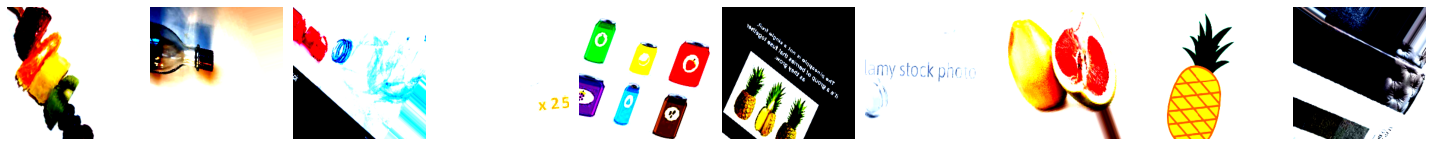

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

# Creación del modelo 


Importamos el modelo DenseNet121 para tomarlo como modelo central

In [ ]:
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, pooling='avg')

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(7, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block6_

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Densnet121 layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%cd '/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Modelo_Pesos_V4'

/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Modelo_Pesos_V4


In [ ]:
history_1st = model.fit(x=train_batches, steps_per_epoch=420, validation_steps=140, validation_data=valid_batches, epochs=30, verbose=1)
model.save("d121_big_v4_BaseModel.h5")
print("Saved to drive")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 420 steps, validate for 140 steps
Epoch 1/30
420/420 [==============================] - 2314s 6s/step - loss: 1.3602 - accuracy: 0.5202 - val_loss: 0.5868 - val_accuracy: 0.8057
Epoch 2/30
420/420 [==============================] - 76s 180ms/step - loss: 0.9955 - accuracy: 0.6645 - val_loss: 0.5524 - val_accuracy: 0.8164
Epoch 3/30
420/420 [==============================] - 74s 176ms/step - loss: 0.9090 - accuracy: 0.6974 - val_loss: 0.4720 - val_accuracy: 0.8307
Epoch 4/30
420/420 [==============================] - 73s 173ms/step - loss: 0.8370 - accuracy: 0.7183 - val_loss: 0.5558 - val_accuracy: 0.8279
Epoch 5/30
420/420 [==============================] - 73s 173ms/step - loss: 0.8272 - accuracy: 0.7210 - val_loss: 0.4940 - val_accuracy: 0.8414
Epoch 6/30
420/420 [==============================] - 71s 169ms/step - loss: 0.7942 - accuracy: 0.7357 - val_loss: 0.5190 - val_accuracy: 0.8550
Epoch 7/30
420/420 [=================

In [ ]:
def graph_metrics(x,val_acc,val_loss, acc, loss, title):
  fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
  ax1.plot(x, loss, label='Train')
  ax1.plot(x, val_loss, label='Validation')
  ax1.set_title('Loss')
  ax1.set(xlabel='Epochs', ylabel='Loss')
  ax1.legend()
  ax2.plot(x, acc, label='Train')
  ax2.plot(x, val_acc, label='Validation')
  ax2.set_title('Accuracy')
  ax2.set(xlabel='Epochs', ylabel='Accuracy')
  ax2.legend()
  fig.suptitle(title, fontsize=16)

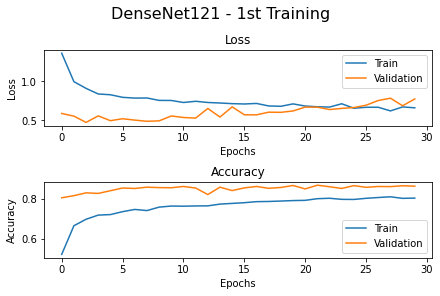

In [ ]:
epochs = 30
title_1 = 'DenseNet121 - 1st Training'
acc = history_1st.history['accuracy']
loss = history_1st.history['loss']
val_acc = history_1st.history['val_accuracy']
val_loss = history_1st.history['val_loss']
x = range(epochs)

graph_metrics(x,val_acc,val_loss, acc, loss, title_1)

In [ ]:
for layer in model.layers[:313]:
   layer.trainable = False
for layer in model.layers[313:]:
   layer.trainable = True

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2nd = model.fit(x=train_batches, steps_per_epoch=420, validation_steps=140, validation_data=valid_batches, epochs=20, verbose=1)
model.save("d121_big_v4_BaseModel.h5")
print("Saved to drive")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 420 steps, validate for 140 steps
Epoch 1/20
420/420 [==============================] - 81s 193ms/step - loss: 0.5030 - accuracy: 0.8326 - val_loss: 0.7166 - val_accuracy: 0.8621
Epoch 2/20
420/420 [==============================] - 72s 170ms/step - loss: 0.4070 - accuracy: 0.8560 - val_loss: 0.6753 - val_accuracy: 0.8650
Epoch 3/20
420/420 [==============================] - 70s 167ms/step - loss: 0.3946 - accuracy: 0.8662 - val_loss: 0.6703 - val_accuracy: 0.8679
Epoch 4/20
420/420 [==============================] - 70s 166ms/step - loss: 0.3631 - accuracy: 0.8767 - val_loss: 0.6612 - val_accuracy: 0.8657
Epoch 5/20
420/420 [==============================] - 69s 165ms/step - loss: 0.3414 - accuracy: 0.8774 - val_loss: 0.6499 - val_accuracy: 0.8686
Epoch 6/20
420/420 [==============================] - 70s 167ms/step - loss: 0.3294 - accuracy: 0.8890 - val_loss: 0.6958 - val_accuracy: 0.8664
Epoch 7/20
420/420 [================

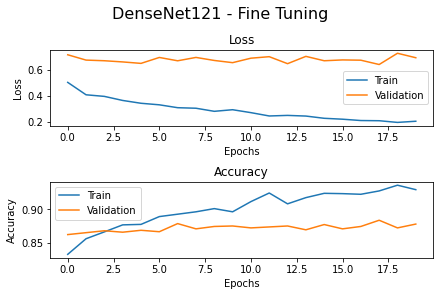

In [ ]:
epochs = 20
title_2 = 'DenseNet121 - Fine Tuning'
acc = history_2nd.history['accuracy']
loss = history_2nd.history['loss']
val_acc = history_2nd.history['val_accuracy']
val_loss = history_2nd.history['val_loss']
x = range(epochs)

graph_metrics(x,val_acc,val_loss, acc, loss, title_2)

In [ ]:
model.evaluate(x=test_batches, verbose=1, steps=140)

  ...
    to  
  ['...']
140/140 [==============================] - 555s 4s/step - loss: 0.6983 - accuracy: 0.8700


[0.6982954453960897, 0.87]

# Predicciones del modelo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

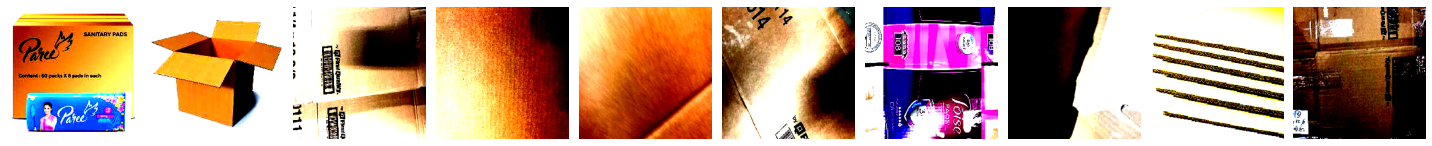

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
predictions = model.predict(x=test_batches, verbose=1, steps=140)

140/140 [==============================] - 9s 62ms/step


In [ ]:
np.round(predictions)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'cardboard': 0,
 'glass': 1,
 'metal': 2,
 'organic': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

Confusion matrix, without normalization
[[186   0   1   2   4   0   7]
 [  0 180  11   2   1   5   1]
 [  6   4 172   1   0   4  13]
 [  5   2   1 178   1   2  11]
 [ 25   3   4   6 155   4   3]
 [  3   7   6   4   0 156  24]
 [  5   0   0   2   0   2 191]]


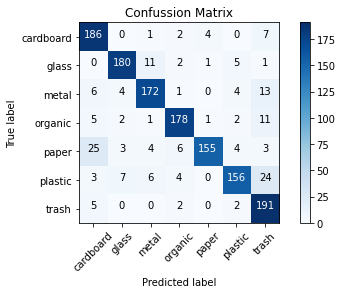

In [ ]:
cm_plot_labels = ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confussion Matrix')

# Pruebas con imágenes propias

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from google.colab.patches import cv2_imshow

In [ ]:
%cd '/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Custom_images'

/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Custom_images


<class 'tensorflow.python.framework.ops.EagerTensor'>


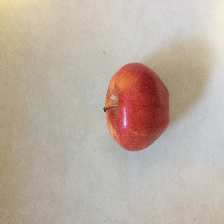

Class: organic 100.0%


In [ ]:
# Preprocessing of image
img_name = 'O4.JPG'

classes = ['cardboard','glass','metal','organic','paper','plastic','trash']
image = tf.image.decode_jpeg(tf.io.read_file(img_name), channels=3)
image_dim = np.expand_dims(image, axis=0)
image_res = tf.image.resize_with_pad(image_dim, 224, 224, method='bilinear', antialias=True)
print(type(image))
image_pre = preprocess_input(image_res)

img_disp = cv2.imread(img_name, cv2.IMREAD_COLOR)
img_disp = cv2.resize(img_disp, (224, 224))
cv2_imshow(img_disp)

results = model.predict(image_pre)
print('Class: ' + classes[np.argmax(results)] + ' ' + str(round(results[0,np.argmax(results)]*100, 2)) + '%')

Hasta este punto se tiene un modelo que clasifica correctamente muchas de las imágenes, pero requiere de un preprocesado manual antes de ingresar imágen al modelo.

Ahora se intentará realizar la integración de las capas de preprocesado en el modelo creado y se observarán los resultados.

# PRUEBA: Modelo con preprocesado

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input

In [ ]:
%cd '/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Modelo_Pesos_V4'

/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Modelo_Pesos_V4


In [ ]:
# load model
model_use = load_model('d121_big_v4_BaseModel.h5')
# summarize model.
model_use.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
i = Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = preprocess_input(x)
x = model_use(x)
model_new = Model(inputs=[i], outputs=[x])

In [ ]:
model_new.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_Cast_3 (TensorFl [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_truediv_28 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd_14 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_truediv_29 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
model_5 (Model)              (None, 7)                 7301703   
Total params: 7,301,703
Trainable params: 2,424,327
Non-trainable params: 4,877,376
________________________________________

In [ ]:
model_new.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_new.save("d121_big_v4.h5")
print("Saved to drive")

Saved to drive


In [ ]:
%cd '/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121'

/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121


In [ ]:
# model_new.save('export/Servo/1')
model_new.save('export_test/Servo/1')

INFO:tensorflow:Assets written to: export_test/Servo/1/assets


In [ ]:
model_new.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_Cast_2 (TensorFl [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_truediv_26 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd_13 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_truediv_27 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
model_5 (Model)              (None, 7)                 7301703   
Total params: 7,301,703
Trainable params: 2,424,327
Non-trainable params: 4,877,376
________________________________________

In [ ]:
predictions_new = model_new.predict(x=test_batches_nopre, verbose=1, steps=140)

140/140 [==============================] - 9s 62ms/step


In [ ]:
np.round(predictions_new)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
cm_new = confusion_matrix(y_true=test_batches_nopre.classes, y_pred=np.argmax(predictions_new, axis=-1))

Confusion matrix, without normalization
[[189   1   3   1   2   0   4]
 [  0 181  13   0   0   4   2]
 [  5   2 177   3   2   5   6]
 [  5   1   1 183   0   0  10]
 [ 20   3   9   9 149   5   5]
 [  4   9   6   5   0 152  24]
 [  4   0   1   5   0   3 187]]


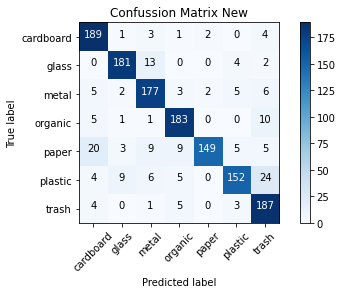

In [ ]:
cm_plot_labels = ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm_new, classes=cm_plot_labels, title='Confussion Matrix New')

Aparentemente funcionó de manera adecuada, procedemos a hacer la prueba con imágenes propias.

# PRUEBA: Predicciones con imágenes propias

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
%cd '/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Custom_images'

/content/drive/My Drive/Saturdays AI - Equipo Dorado/Código/Modelo DenseNet121/Custom_images


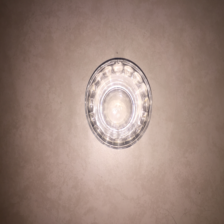

Class: glass 98.42%


In [ ]:
classes = ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']
img_name = 'G1.JPG'


data_s = Image.open(img_name)
image_res = data_s.resize((224,224), Image.BILINEAR)
image_dim = np.array(image_res)
image_dim = np.expand_dims(image_dim, axis=0)

display(image_res)

results = model_new.predict(image_dim)
print('Class: ' + classes[np.argmax(results)] + ' ' + str(round(results[0,np.argmax(results)]*100, 2)) + '%')